In [1]:
%pip install optuna
%pip install imbalanced-learn
%pip install xgboost
%pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import optuna
import gc
import imblearn
import xgboost as xgb
import scikitplot as skplt

# Leitura dos dados

In [3]:
data_path = './TRNcod.xls'

In [4]:
df = pd.read_csv(data_path, sep='\t', encoding='utf-8')

In [125]:
df.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
0,1,1,1,0,0,0,0,0.135098,1,0.222222,...,0,1,1,0,1,1,1,0,1,1
1,1,0,1,0,0,1,0,0.273504,1,0.111111,...,1,0,1,1,0,0,0,1,0,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,...,1,0,0,0,0,1,0,1,0,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,...,1,0,1,1,0,1,0,1,0,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,...,1,1,0,0,1,0,1,1,0,0


In [6]:
df.drop(['INDEX'], axis=1, inplace=True)

#### Combinando classes em uma única coluna

In [7]:
def label_class (row):
   if row['IND_BOM_1_1'] == 1 and row['IND_BOM_1_2'] == 1:
      return 2
   if row['IND_BOM_1_1'] == 1:
      return 0
   if row['IND_BOM_1_2'] == 1:
      return 1
   return 3

In [8]:
df['class'] = df.apply (lambda row: label_class(row), axis=1)

In [9]:
df.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
0,1,1,1,0,0,0,0,0.135098,1,0.222222,...,0,1,1,0,1,1,1,0,1,1
1,1,0,1,0,0,1,0,0.273504,1,0.111111,...,1,0,1,1,0,0,0,1,0,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,...,1,0,0,0,0,1,0,1,0,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,...,1,0,1,1,0,1,0,1,0,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,...,1,1,0,0,1,0,1,1,0,0


In [10]:
print('classe 0:', len(df[df['class'] == 0]))
print('classe 1:', len(df[df['class'] == 1]))
print('classe desconhecida:', len(df[df['class'] > 1]))

classe 0: 255098
classe 1: 134098
classe desconhecida: 0


# Particionamento dos dados

### Particionamento dos dados - 1ª Etapa

In [11]:
x_class_0 = df[df['class'] == 0]
x_class_1 = df[df['class'] == 1]

In [12]:
x_class_0.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
1,1,0,1,0,0,1,0,0.273504,1,0.111111,...,1,0,1,1,0,0,0,1,0,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,...,1,0,0,0,0,1,0,1,0,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,...,1,0,1,1,0,1,0,1,0,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,...,1,1,0,0,1,0,1,1,0,0
5,0,1,1,0,0,0,1,0.219323,0,0.111111,...,1,1,0,1,0,0,1,1,0,0


In [13]:
x_class_1.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2,class
0,1,1,1,0,0,0,0,0.135098,1,0.222222,...,0,1,1,0,1,1,1,0,1,1
10,1,0,1,1,0,0,0,0.654703,0,0.111111,...,1,0,1,0,0,0,0,0,1,1
11,1,1,1,0,0,0,0,0.097444,1,0.111111,...,1,0,1,0,1,0,1,0,1,1
12,1,0,1,0,1,0,0,0.398961,0,0.111111,...,1,1,0,1,0,0,0,0,1,1
17,1,1,1,0,0,0,0,0.142254,0,0.111111,...,0,0,1,0,1,0,1,0,1,1


### Particionamento dos dados - 2ª Etapa

In [14]:
y_class_0 = x_class_0['class'].values
y_class_1 = x_class_1['class'].values

### Particionamento dos dados - 3ª Etapa

Os dados foram divididos aleatoriamente usando o método train_test_split()
- 50% dos dados para treinamento
- Dos 50% restantes, metade(25% do total) pra validação e o restante(25%) para teste

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train_class_0, X_rem_class_0, y_train_class_0, y_rem_class_0 = train_test_split(x_class_0, y_class_0, train_size=0.5)
X_valid_class_0, X_test_class_0, y_valid_class_0, y_test_class_0 = train_test_split(X_rem_class_0, y_rem_class_0, test_size=0.5)

In [17]:
X_train_class_1, X_rem_class_1, y_train_class_1, y_rem_class_1 = train_test_split(x_class_1, y_class_1, train_size=0.5)
X_valid_class_1, X_test_class_1, y_valid_class_1, y_test_class_1 = train_test_split(X_rem_class_1, y_rem_class_1, test_size=0.5)

In [18]:
X_train = pd.concat([X_train_class_0, X_train_class_1])
y_train = np.concatenate((y_train_class_0, y_train_class_1))
X_train = X_train.drop(['class', 'IND_BOM_1_1', 'IND_BOM_1_2'], axis=1)

In [19]:
X_valid = pd.concat([X_valid_class_0, X_valid_class_1])
y_valid = np.concatenate((y_valid_class_0, y_valid_class_1))
X_valid = X_valid.drop(['class', 'IND_BOM_1_1', 'IND_BOM_1_2'], axis=1)

In [20]:
X_test = pd.concat([X_test_class_0, X_test_class_1])
y_test = np.concatenate((y_test_class_0, y_test_class_1))
X_test = X_test.drop(['class', 'IND_BOM_1_1', 'IND_BOM_1_2'], axis=1)

In [21]:
print('Quantidade de entradas para treino:', len(X_train), len(y_train))
print('Quantidade de entradas para validação:', len(X_valid), len(y_valid))
print('Quantidade de entradas para teste:', len(X_test), len(y_test))

Quantidade de entradas para treino: 194598 194598
Quantidade de entradas para validação: 97298 97298
Quantidade de entradas para teste: 97300 97300


### Oversampling - Replicar a classe minoritária para ficar do tamanho da classe majoritária

In [22]:
print('Quantidade antes do over sampling')
print('Quantidade classe 0 treino:', (y_train == 0).sum())
print('Quantidade classe 1 treino:', (y_train == 1).sum())
print('Quantidade classe 0 valid:', (y_valid == 0).sum())
print('Quantidade classe 1 valid:', (y_valid == 1).sum())
print('Quantidade classe 0 test:', (y_test == 0).sum())
print('Quantidade classe 1 test:', (y_test == 1).sum())

Quantidade antes do over sampling
Quantidade classe 0 treino: 127549
Quantidade classe 1 treino: 67049
Quantidade classe 0 valid: 63774
Quantidade classe 1 valid: 33524
Quantidade classe 0 test: 63775
Quantidade classe 1 test: 33525


In [23]:
from imblearn.over_sampling import SMOTE

In [24]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [25]:
print('Quantidade classe 0 treino:', (y_train == 0).sum())
print('Quantidade classe 1 treino:', (y_train == 1).sum())

Quantidade classe 0 treino: 127549
Quantidade classe 1 treino: 127549


In [26]:
oversample = SMOTE()
X_valid, y_valid = oversample.fit_resample(X_valid, y_valid)

In [27]:
print('Quantidade classe 0 valid:', (y_valid == 0).sum())
print('Quantidade classe 1 valid:', (y_valid == 1).sum())

Quantidade classe 0 valid: 63774
Quantidade classe 1 valid: 63774


In [28]:
print('Quantidade classe 0 test:', (y_test == 0).sum())
print('Quantidade classe 1 test:', (y_test == 1).sum())

Quantidade classe 0 test: 63775
Quantidade classe 1 test: 33525


# Funções auxiliares para métricas

Métricas utilizadas:

- Teste estatístico Kolmogorov-Smirnov (KS)

- Acurácia

- Recall

- Precision

- F1-Score

- Auroc (Área sob a Curva Roc)

- Matriz de confusão
      [TP  FP]
      [FN  TN]

In [30]:
### VALIDAR: Teste estatístico Kolmogorov-Smirnov -KS (principal)
### TODO: Adiconar alguns plots

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, RocCurveDisplay

import matplotlib
import matplotlib.pyplot as plt

In [30]:
def plot_ks_statistic(y, y_pred_scores=None):
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()

In [191]:
def plot_roc_curve(actual, pred_proba):
    skplt.metrics.plot_roc(actual, pred_proba)
    plt.show()

In [189]:
def print_metrics(actual, pred, pred_proba):
    print('Accuracy: {:.4f}'.format(accuracy_score(actual, pred)))
    print('Recall: {:.4f}'.format(recall_score(actual, pred)))
    print('Precision: {:.4f}'.format(precision_score(actual, pred)))
    print('F1-Score: {:.4f}'.format(f1_score(actual, pred)))
    print('ROC AUC Score: {:.4f}'.format(roc_auc_score(actual, pred_proba[:, 1])))
    print('Matriz de confusão no conjunto de teste:')
    print(confusion_matrix(actual, pred))
    plot_ks_statistic(actual, pred_proba)
    plot_roc_curve(actual, pred_proba)

In [164]:
def eval_metrics(actual, pred):
    accuracy = accuracy_score(actual, pred)
    recall = recall_score(actual, pred)
    precision = precision_score(actual, pred)
    f1 = f1_score(actual, pred)
    return accuracy, recall, precision, f1

# Algoritmos

In [167]:
n_trials=10

### Modelo MLP

Descrição dos principais parâmetros:

 - hidden_layer_sizes: tupla, comprimento da camada oculta. O padrão é (100,), o que significa uma única camada oculta com 100 neurônios.

 - activation: função de ativação para a camada oculta. Os valores possíveis são ‘identity’, ‘logistic’, ‘tanh’, ‘relu’. O padrão é ‘relu’.

 - learning_rate_init: a taxa de aprendizado inicial para ‘sgd’ ou ‘adam’. O padrão é 0,001. Nota: a taxa de aprendizado é sempre modificada para ‘learning_rate_init’ quando ‘learning_rate’ é definido como ‘invscaling’ ou ‘adaptive’.

In [126]:
from sklearn.neural_network import MLPClassifier

1ª Configuração

In [179]:
mlp_clf = MLPClassifier()

In [180]:
%%time
mlp_clf.fit(X_train, y_train)

CPU times: user 4h 35min 11s, sys: 5h 2min 25s, total: 9h 37min 36s
Wall time: 24min 4s


/home/ubuntu/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier()

In [181]:
y_mlp_pred_test = mlp_clf.predict(X_test)
y_mlp_pred_test_proba = mlp_clf.predict_proba(X_test)

Accuracy: 0.6526
Recall: 0.3934
Precision: 0.4948
F1-Score: 0.4383
ROC AUC Score: 0.6537
Matriz de confusão no conjunto de teste:
[[50307 13468]
 [20335 13190]]


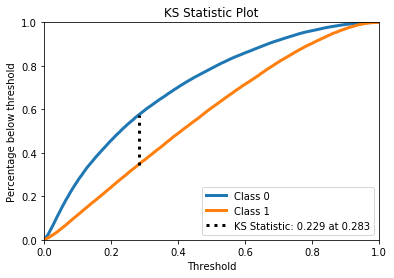

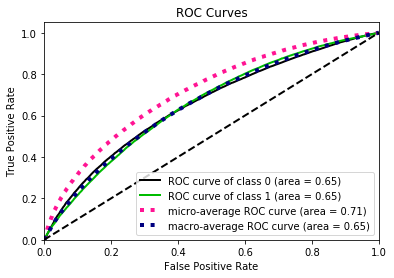

In [192]:
print_metrics(y_test, y_mlp_pred_test, y_mlp_pred_test_proba)

In [202]:
def mlp_fn(trial):
  # Define the search space
    params = {
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.001, 0.1, step=0.001),
        'first_layer_neurons': trial.suggest_int('first_layer_neurons', 10, 100, step=10),
        'second_layer_neurons': trial.suggest_int('second_layer_neurons', 10, 100, step=10),
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh',  'relu'])
    }

    mlp_reg = MLPClassifier(
        hidden_layer_sizes=(params['first_layer_neurons'], params['second_layer_neurons']),
        learning_rate_init=params['learning_rate_init'],
        activation=params['activation'],
        random_state=42
    )

    mlp_reg.fit(X_train, y_train)

    y_pred_valid = mlp_reg.predict(X_valid)

    (accuracy, recall, precision, f1) = eval_metrics(y_valid, y_pred_valid)

    gc.collect()

    return accuracy

In [203]:
mlp_study = optuna.create_study(direction="maximize")

[I 2022-10-06 15:28:39,135] A new study created in memory with name: no-name-10c7d726-092e-44fd-9873-076066029aac


In [204]:
mlp_study.optimize(mlp_fn, n_trials=n_trials)

[I 2022-10-06 15:34:15,875] Trial 0 finished with value: 0.6332674757738264 and parameters: {'learning_rate_init': 0.076, 'first_layer_neurons': 80, 'second_layer_neurons': 90, 'activation': 'logistic'}. Best is trial 0 with value: 0.6332674757738264.
/home/ubuntu/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2022-10-06 15:35:01,907] Trial 1 finished with value: 0.5 and parameters: {'learning_rate_init': 0.04, 'first_layer_neurons': 10, 'second_layer_neurons': 90, 'activation': 'relu'}. Best is trial 0 with value: 0.6332674757738264.
[I 2022-10-06 15:41:59,332] Trial 2 finished with value: 0.6702496315112741 and parameters: {'learning_rate_init': 0.07200000000000001, 'first_layer_neurons': 80, 'second_layer_neurons': 100, 'activation': 'logistic'}

In [205]:
mlp_study.best_params

{'learning_rate_init': 0.006,
 'first_layer_neurons': 80,
 'second_layer_neurons': 30,
 'activation': 'relu'}

In [206]:
def mlp_test(params):
    mlp_reg = MLPClassifier(
        hidden_layer_sizes=(params['first_layer_neurons'], params['second_layer_neurons']),
        learning_rate_init=params['learning_rate_init'],
        activation=params['activation'],
        random_state=42
    )

    mlp_reg.fit(X_train, y_train)

    y_pred_test = mlp_reg.predict(X_test)
    y_pred_test_proba = mlp_reg.predict_proba(X_test)

    print_metrics(y_test, y_pred_test, y_pred_test_proba)

    gc.collect()

Accuracy: 0.6650
Recall: 0.4277
Precision: 0.5167
F1-Score: 0.4680
ROC AUC Score: 0.6799
Matriz de confusão no conjunto de teste:
[[50364 13411]
 [19187 14338]]


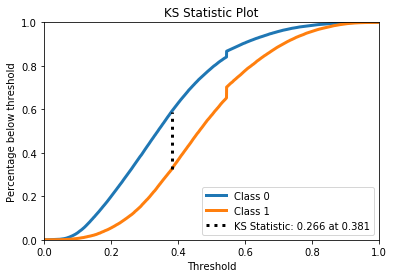

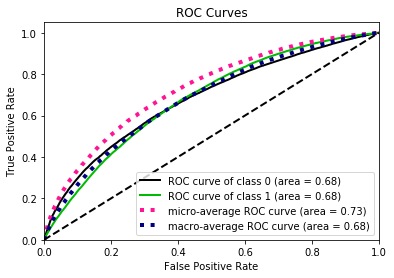

In [207]:
mlp_test(mlp_study.best_params)

### Modelo Random Forest

Descrição dos parâmetros:

- n_estimators
  - O número de árvores na floresta.

- criterion
  - A função para medir a qualidade de uma divisão

- max_depth
  - A profundidade máxima da árvore.
  - 'None' significa que os nós são expandidos até que todas as folhas sejam puras(se o nó possui prediz apenas 1 classe) ou até que todas as folhas contenham menos de min_samples_split amostras.

- min_samples_split
  - O número mínimo de amostras necessárias para dividir um nó.

- min_samples_leaf
  - O número mínimo de amostrar necessárias para ser um nó folha.

- max_features
  - O número de features a serem considerados ao procurar a melhor divisão. Por exemplo, caso a função seja 'sqrt', a cada divisão ele tenta buscar uma condição que possua sqrt(n_node) entradas. 

- max_leaf_nodes
  - O número max de nós folha. 
  - 'None' significa então pode haver um número ilimitado de nós folha.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#### 1ª Configuração

A primeira configuração é utilizada com os parâmetros padrões do Sklearn.

Segue abaixo a lista dos principais hiperparâmetros:

- n_estimators = 100

- criterion = 'gini'

- max_depth = None 

- min_samples_split = 2

- min_samples_leaf = 1

- max_features = 'sqrt'

- max_leaf_nodes = None

In [168]:
clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [169]:
%%time
history_rf = clf_rf.fit(X_train, y_train)

CPU times: user 8min 4s, sys: 4.72 s, total: 8min 9s
Wall time: 23.6 s


In [170]:
y_test_pred_rf = clf_rf.predict(X_test)

In [171]:
y_test_proba_rf = clf_rf.predict_proba(X_test)

##### 1a Análise de Desempenho

Accuracy: 0.6699
Recall: 0.3792
Precision: 0.5292
F1-Score: 0.4418
ROC AUC Score: 0.6796
Matriz de confusão no conjunto de teste:
[[52467 11308]
 [20812 12713]]


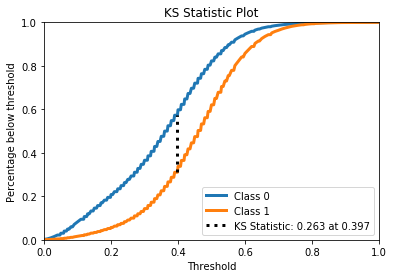

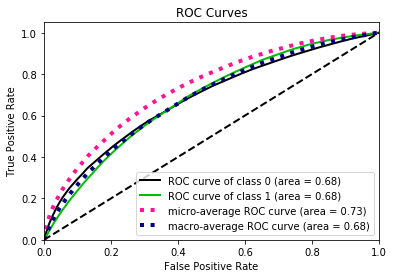

In [194]:
print_metrics(y_test, y_test_pred_rf, y_test_proba_rf)

#### 2ª Configuração

Para a segunda configuração vamos criar um estudo de caso usando o optuna, variando alguns hiperparâmetros

In [173]:
def random_forest(trial):
    params = {
        'n_estimators':  trial.suggest_int('n_estimators', 30, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 10000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 1, 10000)
    }
    # Create the model
    rnd_forest = RandomForestClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        max_leaf_nodes=params["max_leaf_nodes"],
        random_state=0,
        n_jobs=-1
    )

    rnd_forest.fit(X_train, y_train)

    y_pred_valid = rnd_forest.predict(X_valid)
    y_pred_proba = rnd_forest.predict_proba(X_valid)

    (accuracy, recall, precision, f1) = eval_metrics(y_valid, y_pred_valid)

    gc.collect()
    return accuracy

In [177]:
rf_study = optuna.create_study(direction="maximize")

[I 2022-10-06 12:53:47,279] A new study created in memory with name: no-name-bc9cdc14-107d-47be-8cc5-761a1b03bb4b


In [178]:
%%time
rf_study.optimize(random_forest, n_trials=n_trials)

[I 2022-10-06 12:56:48,594] Trial 0 finished with value: 0.7435240066484774 and parameters: {'n_estimators': 899, 'max_depth': 2009, 'max_leaf_nodes': 9722}. Best is trial 0 with value: 0.7435240066484774.
[I 2022-10-06 12:58:36,653] Trial 1 finished with value: 0.7313011572114028 and parameters: {'n_estimators': 849, 'max_depth': 6633, 'max_leaf_nodes': 208}. Best is trial 0 with value: 0.7435240066484774.
[I 2022-10-06 12:59:42,858] Trial 2 finished with value: 0.7422460563866152 and parameters: {'n_estimators': 384, 'max_depth': 6289, 'max_leaf_nodes': 2508}. Best is trial 0 with value: 0.7435240066484774.
[I 2022-10-06 13:01:40,585] Trial 3 finished with value: 0.7431476777370088 and parameters: {'n_estimators': 628, 'max_depth': 5288, 'max_leaf_nodes': 5278}. Best is trial 0 with value: 0.7435240066484774.
[I 2022-10-06 13:02:29,961] Trial 4 finished with value: 0.7423009376862044 and parameters: {'n_estimators': 279, 'max_depth': 5346, 'max_leaf_nodes': 2450}. Best is trial 0 wit

CPU times: user 7h 44min 28s, sys: 13 s, total: 7h 44min 41s
Wall time: 19min 57s


In [183]:
rf_study.best_params

{'n_estimators': 899, 'max_depth': 2009, 'max_leaf_nodes': 9722}

In [195]:
def random_forest_test(params):
    rnd_forest = RandomForestClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        max_leaf_nodes=params["max_leaf_nodes"],
        random_state=0,
        n_jobs=-1
    )

    rnd_forest.fit(X_train, y_train)

    y_pred_test = rnd_forest.predict(X_test)
    y_pred_test_proba = rnd_forest.predict_proba(X_test)
    
    print_metrics(y_test, y_pred_test, y_pred_test_proba)

In [196]:
params = rf_study.best_params

Accuracy: 0.6805
Recall: 0.4057
Precision: 0.5493
F1-Score: 0.4667
ROC AUC Score: 0.6985
Matriz de confusão no conjunto de teste:
[[52614 11161]
 [19924 13601]]


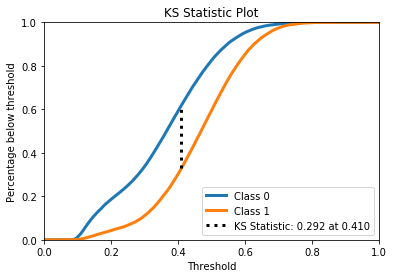

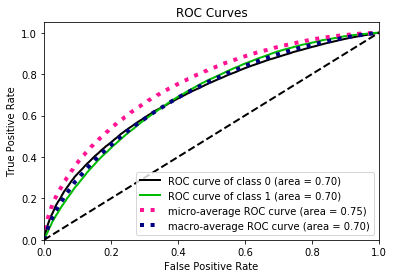

In [197]:
random_forest_test(params)

### Modelo SVM

Descrição dos principais parâmetros:

- C
  - Parâmetro de regularização. A força da regularização é inversamente proporcional a C. Deve ser estritamente positiva. A penalidade é uma penalidade de 12 ao quadrado.

- kernel
  - Especifica o tipo de kernel a ser usado no algoritmo. Se nenhum for fornecido, 'rbf' será usado. Se um callable for fornecido, ele será usado para pré-computar a matriz do kernel a partir de matrizes de dados; essa matriz deve ser uma matriz de forma
  - Valor default: rbf

- degree
  - Grau da função kernel polinomial ('poli'). Ignorado por todos os outros kernels.
  - Valor default: 3

- gamma
  - Coeficiente de kernel para 'rbf', 'poli' e 'sigmóide'


In [93]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf_svm = SVC(gamma='auto', probability=True)

In [ ]:
%%time
# clf_svm.fit(X_train, y_train)

In [104]:
# y_valid_pred_svm = clf_svm.predict(X_valid)
# y_valid_pred_svm

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# y_valid_proba_svm = clf_svm.predict_proba(X_valid)

##### Análise de Desempenho

In [ ]:
# print('Métricas da 1ª configuração do SVM:\n')
# print_metrics(y_valid, y_valid_pred_svm, y_valid_proba_svm)

**Segundo a própria documentação do Scikit learn para dataset muito grandes é aconselhável usarmos o LinearSVC**

In [35]:
from sklearn.svm import LinearSVC
clf_svm_linear = LinearSVC(random_state=0, tol=1e-5)

In [36]:
%%time
# clf_svm_linear.fit(X_train, y_train)

2022/09/29 18:47:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4ef9cc0f2cab4272b1b1510c507545cf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
/home/ubuntu/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
2022/09/29 18:51:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ubuntu/.local/lib/python3.7/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) th

CPU times: user 4min 11s, sys: 10.2 s, total: 4min 22s
Wall time: 4min 11s


LinearSVC(random_state=0, tol=1e-05)

In [38]:
# y_valid_pred_svm_linear = clf_svm_linear.predict(X_valid)

##### Análise de Desempenho

In [39]:
print('Métricas da 1ª configuração do SVM SVC Linear:\n')
print_metrics(y_valid, y_valid_pred_svm_linear,None)

Métricas da 1ª configuração do SVM SVC Linear:

Accuracy: 0.7301
Recall: 0.6573
Precision: 0.7692
F1-Score: 0.7089
Matriz de confusão no conjunto de teste:
[[51199 12575]
 [21854 41920]]


In [ ]:
compute_performance_metrics(y_test, y_pred_class, y_pred_scores)

### Modelo AdaBoost

Definição dos parâmetros
* base_estimator object, default=None
    * O estimador base a partir do qual o conjunto impulsionado é construído. É necessário suporte para ponderação de amostra, bem como atributos classes_ e n_classes_ apropriados. Se Nenhum, então o estimador base é DecisionTreeClassifier inicializado com max_depth=1.

* n_estimators int, default=50
    * O número máximo de estimadores em que o reforço é encerrado. Em caso de ajuste perfeito, o processo de aprendizagem é interrompido precocemente. Os valores devem estar no intervalo [1, inf).

* learning_rate float, default=1.0
    * Peso aplicado a cada classificador em cada iteração de reforço. Uma taxa de aprendizado mais alta aumenta a contribuição de cada classificador. Há um trade-off entre os parâmetros learning_rate e n_estimators. Os valores devem estar no intervalo (0,0, inf).

* algorithm {‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’
    * Se 'SAMME.R', use o algoritmo de reforço real SAMME.R. base_estimator deve suportar o cálculo de probabilidades de classe. Se 'SAMME', use o algoritmo de reforço discreto SAMME. O algoritmo SAMME.R normalmente converge mais rápido que o SAMME, alcançando um erro de teste menor com menos iterações de reforço.

* random_state int, RandomState instance or None, default=None
    * Controla a semente aleatória fornecida em cada base_estimator em cada iteração de reforço. Assim, ele só é usado quando base_estimator expõe um random_state. Passe um int para saída reproduzível em várias chamadas de função. Consulte Glossário.

In [98]:
from sklearn.ensemble import AdaBoostClassifier

#### 1ª Configuração

A primeira configuração é utilizada com os parâmetros padrões do Sklearn.

Segue abaixo a lista dos principais hiperparâmetros:

- n_estimators = 100

- learning_rate = 1

- algorithm = SAMME.R

- random_state = 1


In [99]:
clf_adaBoost = AdaBoostClassifier(n_estimators=100, learning_rate = 1, random_state=0)

In [ ]:
%%time
history_adaBoost = clf_adaBoost.fit(X_train, y_train)

In [ ]:
y_valid_pred_adaBoost = clf_adaBoost.predict(X_valid)

In [ ]:
y_valid_proba_adaBoost = clf_adaBoost.predict_proba(X_valid)

##### Análise de Desempenho

In [ ]:
print('Métricas da 1ª configuração do Adaboost:\n')
print_metrics(y_valid, y_valid_pred_adaBoost, y_valid_proba_adaBoost)

### Modelo Gradient Boosting

Descrição dos parâmetros:

- loss
  - Possíveis valores: ‘log_loss’, ‘exponential’
  - default=’log_loss’
  - A função de perda a ser otimizada. 
    - 'log_loss' refere-se ao desvio binomial e multinomial, o mesmo usado na regressão logística. É uma boa escolha para classificação com saídas probabilísticas. 
    - 'exponencial', o aumento de gradiente recupera o algoritmo AdaBoost.

- learning_rate
  - Possíveis valores: intervalo (0,0, inf)
  - default=0.1
  - A taxa de aprendizado reduz a contribuição de cada árvore por learning_rate. Há um trade-off entre learning_rate e n_estimators. 

- n_estimators
  - Os valores devem estar no intervalo [1, inf).
  - default=100
  - O número de estágios de reforço a serem executados. 
  - **O aumento de gradiente é bastante robusto ao over-fitting, portanto, um número grande geralmente resulta em melhor desempenho.

- subsample
  - Os valores devem estar no intervalo (0,0, 1,0].
  - default=1.0
  - A fração de amostras a ser usada para ajustar os 'individual base learners'. 
  - Se menor que 1,0, isso resulta em aumento de gradiente estocástico. subamostra interage com o parâmetro n_estimators. 
    - **Escolher subamostra < 1,0 leva a uma redução da variância e a um aumento no viés.

- criterion
  - Possíveis valores: {‘friedman_mse’, ‘squared_error’, ‘mse’}
  - default=’friedman_mse’
  - A função para medir a qualidade de uma divisão. 
  - Os critérios suportados são:
    - ‘friedman_mse’ para o erro quadrático médio com pontuação de melhoria por Friedman, 
    - ‘squared_error’ para erro quadrático médio. 
  - **O valor padrão de ‘friedman_mse’ geralmente é o melhor, pois pode fornecer uma melhor aproximação em alguns casos.

- min_samples_split
  - Possíveis valores: int or float
  - default=2
  - Se int, os valores devem estar no intervalo [1, inf).
  - Se float, os valores devem estar no intervalo (0.0, 1.0] e min_samples_leaf será ceil(min_samples_leaf * n_samples).

- min_samples_leaf
  - Possíveis valores: int or float
  - default=1
  - Isso pode ter o efeito de suavizar o modelo, especialmente na regressão.

- min_weight_fraction_leaf
  - Os valores devem estar no intervalo [0,0, 0,5].
  - default=0.0(As amostras têm peso igual)
  - A fração ponderada mínima da soma total de pesos (de todas as amostras de entrada) necessária para estar em um nó folha. 

- max_depth
  - Os valores devem estar no intervalo [1, inf).
  - default=3
  - Ajuste este parâmetro para melhorar o desempenho; 
    - O melhor valor depende da interação das variáveis de entrada.

- min_impurity_decrease
  - Os valores devem estar no intervalo [0,0, inf).
  - default=0.0
  - Um nó será dividido se esta divisão induzir uma diminuição da impureza maior ou igual a este valor.

- init
  - Possíveis valores: estimator or ‘zero’
  - default=None(é usado um DummyEstimator)
  - Um objeto estimador que é usado para calcular as previsões iniciais. 
  - init tem que fornecer fit e predict_proba. 
  - Se 'zero', as previsões brutas iniciais são definidas como zero. 

- max_features
  - Possíveis valores: {‘auto’, ‘sqrt’, ‘log2’}, int or float
    - Se int, valores devem estar no intervalo  [1, inf).
    - Se float, valores devem estar no intervalo  (0.0, 1.0] and the features considered at each split will be max(1, int(max_features * n_features_in_)).
    - Se f = ‘auto’, ‘sqrt’, ‘log2’, então max_features = f(n_features).
    - Se None, então max_features = n_features.
  - default=None
  - O número de features para considerar quando buscar pelo melhor split.



In [64]:
from sklearn.ensemble import GradientBoostingClassifier

#### 1ª Configuração

A primeira configuração é utilizada com os parâmetros padrões do Sklearn.

Segue abaixo a lista dos principais hiperparâmetros:

- loss
  - default=’log_loss’

- learning_rate
  - default=0.1

- n_estimators
  - default=100

- subsample
  - default=1.0

- criterion
  - default=’friedman_mse’

- min_samples_split
  - default=2

- min_samples_leaf
  - default=1

- min_weight_fraction_leaf
  - default=0.0(As amostras têm peso igual)

- max_depth
  - default=3

- min_impurity_decrease
  - default=0.0

- init
  - default=None(é usado um DummyEstimator)

- max_features
  - default=None(então max_features = n_features.)




In [62]:
clf_gb = xgb.XGBClassifier(random_state=27)

In [63]:
%%time
clf_gb.fit(X_train, y_train)

CPU times: user 15min 46s, sys: 672 ms, total: 15min 47s
Wall time: 40.5 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=27,
              reg_alpha=0, reg_lambda=1, ...)

In [64]:
y_pred_gb = clf_gb.predict(X_valid)

In [65]:
y_proba_gb = clf_gb.predict_proba(X_valid)

##### Análise de Desempenho

In [66]:
print('Métricas da 1ª configuração do Random Forest:\n')
print_metrics(y_valid, y_pred_gb, y_proba_gb)

Métricas da 1ª configuração do Random Forest:

Accuracy: 0.7570
Recall: 0.6686
Precision: 0.8121
F1-Score: 0.7334
ROC AUC Score: 0.8412
Matriz de confusão no conjunto de teste:
[[53909  9865]
 [21135 42639]]


#### 2ª Configuração

Para a segunda configuração alteramos os seguintes parâmetros:

In [60]:
def gradient_boosting(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate ', 0.0001, 0.1, step=0.005),
        'max_depth': trial.suggest_int('max_depth', 4, 100),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=10)
    }
    # 'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
    # Create the model
    gb_clf_trial = xgb.XGBClassifier(
        learning_rate=params["learning_rate"],
        max_depth=params["max_depth"],
        n_estimators=params["n_estimators"],
        random_state=42
    )
    print("Training model with params", params)
    gb_clf_trial.fit(X_train, y_train)

    y_pred_valid = gb_clf_trial.predict(X_valid)
    y_pred_proba = gb_clf_trial.predict_proba(X_valid)

    (accuracy, recall, precision, f1) = eval_metrics(y_valid, y_pred_valid)

    gc.collect()
    return accuracy

In [61]:
gb = optuna.create_study(direction="maximize")
gb.optimize(gradient_boosting, n_trials=10)

[I 2022-09-30 03:41:51,757] A new study created in memory with name: no-name-6d9d3dc5-6165-4317-b52f-c71c0067ae07
/home/ubuntu/.local/lib/python3.7/site-packages/optuna/distributions.py:671: UserWarning: The distribution is specified by [0.0001, 0.1] and step=0.005, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.0951].
  low=low, old_high=old_high, high=high, step=step


Training model with params {'learning_rate': 0.0751, 'max_depth': 5, 'n_estimators': 190}


[I 2022-09-30 03:42:56,244] Trial 0 finished with value: 0.7599570357826073 and parameters: {'learning_rate ': 0.0751, 'max_depth': 5, 'n_estimators': 190}. Best is trial 0 with value: 0.7599570357826073.
/home/ubuntu/.local/lib/python3.7/site-packages/optuna/distributions.py:671: UserWarning: The distribution is specified by [0.0001, 0.1] and step=0.005, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.0951].
  low=low, old_high=old_high, high=high, step=step


Training model with params {'learning_rate': 0.08510000000000001, 'max_depth': 88, 'n_estimators': 110}


[I 2022-09-30 03:49:04,054] Trial 1 finished with value: 0.7464248753410481 and parameters: {'learning_rate ': 0.08510000000000001, 'max_depth': 88, 'n_estimators': 110}. Best is trial 0 with value: 0.7599570357826073.
/home/ubuntu/.local/lib/python3.7/site-packages/optuna/distributions.py:671: UserWarning: The distribution is specified by [0.0001, 0.1] and step=0.005, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.0951].
  low=low, old_high=old_high, high=high, step=step


Training model with params {'learning_rate': 0.0801, 'max_depth': 36, 'n_estimators': 300}


[I 2022-09-30 04:02:31,447] Trial 2 finished with value: 0.7507761783799041 and parameters: {'learning_rate ': 0.0801, 'max_depth': 36, 'n_estimators': 300}. Best is trial 0 with value: 0.7599570357826073.
/home/ubuntu/.local/lib/python3.7/site-packages/optuna/distributions.py:671: UserWarning: The distribution is specified by [0.0001, 0.1] and step=0.005, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.0951].
  low=low, old_high=old_high, high=high, step=step


Training model with params {'learning_rate': 0.0951, 'max_depth': 45, 'n_estimators': 140}


[I 2022-09-30 04:09:48,697] Trial 3 finished with value: 0.748447643240192 and parameters: {'learning_rate ': 0.0951, 'max_depth': 45, 'n_estimators': 140}. Best is trial 0 with value: 0.7599570357826073.
/home/ubuntu/.local/lib/python3.7/site-packages/optuna/distributions.py:671: UserWarning: The distribution is specified by [0.0001, 0.1] and step=0.005, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.0951].
  low=low, old_high=old_high, high=high, step=step


Training model with params {'learning_rate': 0.0101, 'max_depth': 81, 'n_estimators': 120}


[I 2022-09-30 04:18:12,463] Trial 4 finished with value: 0.7250603694295481 and parameters: {'learning_rate ': 0.0101, 'max_depth': 81, 'n_estimators': 120}. Best is trial 0 with value: 0.7599570357826073.
/home/ubuntu/.local/lib/python3.7/site-packages/optuna/distributions.py:671: UserWarning: The distribution is specified by [0.0001, 0.1] and step=0.005, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.0951].
  low=low, old_high=old_high, high=high, step=step


Training model with params {'learning_rate': 0.0601, 'max_depth': 17, 'n_estimators': 100}


[I 2022-09-30 04:21:01,868] Trial 5 finished with value: 0.7539906544986985 and parameters: {'learning_rate ': 0.0601, 'max_depth': 17, 'n_estimators': 100}. Best is trial 0 with value: 0.7599570357826073.
/home/ubuntu/.local/lib/python3.7/site-packages/optuna/distributions.py:671: UserWarning: The distribution is specified by [0.0001, 0.1] and step=0.005, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.0951].
  low=low, old_high=old_high, high=high, step=step


Training model with params {'learning_rate': 0.0951, 'max_depth': 75, 'n_estimators': 220}


[I 2022-09-30 04:31:41,724] Trial 6 finished with value: 0.7493257440336187 and parameters: {'learning_rate ': 0.0951, 'max_depth': 75, 'n_estimators': 220}. Best is trial 0 with value: 0.7599570357826073.
/home/ubuntu/.local/lib/python3.7/site-packages/optuna/distributions.py:671: UserWarning: The distribution is specified by [0.0001, 0.1] and step=0.005, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.0951].
  low=low, old_high=old_high, high=high, step=step


Training model with params {'learning_rate': 0.015099999999999999, 'max_depth': 94, 'n_estimators': 300}


[I 2022-09-30 04:50:08,844] Trial 7 finished with value: 0.7448411578386176 and parameters: {'learning_rate ': 0.015099999999999999, 'max_depth': 94, 'n_estimators': 300}. Best is trial 0 with value: 0.7599570357826073.
/home/ubuntu/.local/lib/python3.7/site-packages/optuna/distributions.py:671: UserWarning: The distribution is specified by [0.0001, 0.1] and step=0.005, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.0951].
  low=low, old_high=old_high, high=high, step=step


Training model with params {'learning_rate': 0.0751, 'max_depth': 7, 'n_estimators': 270}


[I 2022-09-30 04:52:16,947] Trial 8 finished with value: 0.7615407532850378 and parameters: {'learning_rate ': 0.0751, 'max_depth': 7, 'n_estimators': 270}. Best is trial 8 with value: 0.7615407532850378.
/home/ubuntu/.local/lib/python3.7/site-packages/optuna/distributions.py:671: UserWarning: The distribution is specified by [0.0001, 0.1] and step=0.005, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.0951].
  low=low, old_high=old_high, high=high, step=step


Training model with params {'learning_rate': 0.015099999999999999, 'max_depth': 46, 'n_estimators': 200}


[I 2022-09-30 05:05:07,544] Trial 9 finished with value: 0.7403408912723053 and parameters: {'learning_rate ': 0.015099999999999999, 'max_depth': 46, 'n_estimators': 200}. Best is trial 8 with value: 0.7615407532850378.


# Anexos

Descrição dos parâmetros:

- n_estimators
  - O número de árvores na floresta.


In [56]:
%pip install --user tensorflow

Note: you may need to restart the kernel to use updated packages.


In [138]:
from keras.wrappers.scikit_learn import KerasClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

#### 1ª Configuração

A primeira configuração é utilizada com os parâmetros padrões do Sklearn.

Segue abaixo a lista dos principais hiperparâmetros:

- n_

In [139]:
def create_sklearn_compatible_model():
    input_dim = X_train.shape[1]
    
    model = Sequential()
    model.add(Dense(20, activation='tanh', input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [140]:
clf_mlp = KerasClassifier(build_fn=create_sklearn_compatible_model, 
                          batch_size=64, epochs=100,
                          verbose=0)


/home/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  This is separate from the ipykernel package so we can avoid doing imports until


In [141]:
%%time
clf_mlp.fit(X_train, y_train)

CPU times: user 20min 43s, sys: 4min 46s, total: 25min 30s
Wall time: 10min 7s


In [142]:
y_pred_mlp = clf_mlp.predict(X_valid)

3986/3986 [==============================] - 5s 1ms/step


In [143]:
y_proba_mlp = clf_mlp.predict_proba(X_valid)

3986/3986 [==============================] - 4s 1ms/step


##### Análise de Desempenho

Métricas da 1ª configuração do Random Forest:

Accuracy: 0.7307
Recall: 0.6912
Precision: 0.7504
F1-Score: 0.7196
ROC AUC Score: 0.8157
Matriz de confusão no conjunto de teste:
[[49112 14662]
 [19691 44083]]


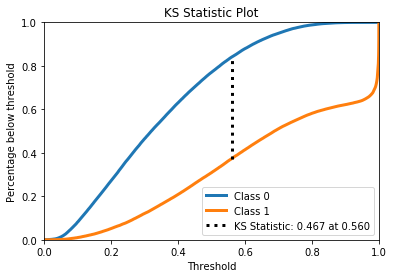

In [146]:
print('Métricas da 1ª configuração do Random Forest:\n')
print_metrics(y_valid, y_pred_mlp, y_proba_mlp)

#### 2ª Configuração

Para a segunda configuração alteramos os seguintes parâmetros:

#### Random Forest usando K-fold Cross Validation

Não teremos mais isso

In [67]:
from sklearn.model_selection import KFold

scores = []
# cv = KFold(n_splits=10, random_state=42, shuffle=True)
kfold = KFold(n_splits=3, shuffle=True)

# for train_index, test_index in cv.split(X_train):
#     print("TRAIN:", train_index, "TEST:", test_index, "LEN:", X_train.loc[255096:255097])
#     X_train2, X_test2, y_train2, y_test2 = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
#     clf_rf.fit(X_train2, y_train2)
#     scores.append(clf_rf.score(X_test2, y_test2))

In [68]:
from sklearn.model_selection import cross_val_score

cross_val_score(clf_rf, X_train, y_train, cv=kfold, scoring='accuracy')

array([0.76057531, 0.76244517, 0.76138395])